In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

import joblib

# Một số thiết lập hiển thị
pd.set_option("display.max_columns", 100)
sns.set(style="whitegrid")

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
ohlcv = pd.read_csv("/kaggle/input/data-for-training/OHLCV_Merge.csv")
share_out = pd.read_csv("/kaggle/input/data-for-training/Share_outstanding.csv")

print("OHLCV_Merge shape:", ohlcv.shape)
print("Share_outstanding shape:", share_out.shape)

display(ohlcv.head())
display(share_out.head())

OHLCV_Merge shape: (700963, 9)
Share_outstanding shape: (3417, 5)


,Unnamed: 0,ticker,date,open,high,low,close,volume,exchange
0,0,AAA,2020-01-02,9.8915,10.0078,9.8139,9.8925,1112410,HOSE
1,1,AAA,2020-01-03,9.8915,10.0078,9.7751,9.8537,1193840,HOSE
2,2,AAA,2020-01-06,9.7751,9.8527,9.5423,9.5433,1823010,HOSE
3,3,AAA,2020-01-07,9.5423,9.7751,9.5423,9.6209,1730250,HOSE
4,4,AAA,2020-01-08,9.5423,9.5811,9.2320,9.3106,3128170,HOSE


,Unnamed: 0.1,Unnamed: 0,Mã,Năm,shares_outstanding
0,0,0,AAA,2020,200183831
1,1,1,AAA,2021,357000015
2,2,2,AAA,2022,352423399
3,3,3,AAA,2023,382312482
4,4,4,AAA,2024,0


In [8]:
data = ohlcv.copy()

# Chuẩn hóa kiểu dữ liệu
data['date'] = pd.to_datetime(data['date'])
data['ticker'] = data['ticker'].astype(str).str.strip().str.upper()

share_out['Mã'] = share_out['Mã'].astype(str).str.strip().str.upper()
share_out['Năm'] = pd.to_numeric(share_out['Năm'], errors='coerce').astype('Int64')

# Sắp xếp theo ticker + date
data = data.sort_values(['ticker', 'date'])

g = data.groupby('ticker')

# 1) Các feature cơ bản theo phiên
# --------------------------------

# Biên độ trong ngày / close
data['range_rel'] = (data['high'] - data['low']) / data['close']

# Vị trí close trong range [low, high]
den = (data['high'] - data['low']).replace(0, np.nan)
data['close_loc'] = (data['close'] - data['low']) / den

# Giá đóng cửa ngày trước đó
data['prev_close'] = g['close'].shift(1)

# Return 1d, 3d, 5d
data['ret_1d'] = data['close'] / data['prev_close'] - 1
data['ret_3d'] = data['close'] / g['close'].shift(3) - 1
data['ret_5d'] = data['close'] / g['close'].shift(5) - 1

# Gap mở cửa so với close hôm trước
data['gap_open'] = (data['open'] - data['prev_close']) / data['prev_close']

# Z-score volume 20 phiên
data['vol_ma20'] = g['volume'].transform(lambda x: x.rolling(20, min_periods=5).mean())
data['vol_std20'] = g['volume'].transform(lambda x: x.rolling(20, min_periods=5).std())
data['vol_z20'] = (data['volume'] - data['vol_ma20']) / data['vol_std20']

# 2) Merge shares_outstanding theo ticker + năm
# --------------------------------------------
data['year'] = data['date'].dt.year

data = data.merge(
    share_out[['Mã', 'Năm', 'shares_outstanding']],
    left_on=['ticker', 'year'],
    right_on=['Mã', 'Năm'],
    how='left'
)

# Làm sạch shares_outstanding
data['shares_outstanding'] = pd.to_numeric(data['shares_outstanding'], errors='coerce')
data.loc[data['shares_outstanding'] <= 0, 'shares_outstanding'] = np.nan

# Turnover = khối lượng / shares_outstanding
data['turnover'] = data['volume'] / data['shares_outstanding']

g2 = data.groupby('ticker')

# 3) Rolling feature 3d, 5d, 10d
# -------------------------------

# --- 3 ngày ---
data['turnover_3d'] = g2['turnover'].transform(lambda x: x.rolling(3, min_periods=1).mean())
data['range_3d'] = g2['range_rel'].transform(lambda x: x.rolling(3, min_periods=1).mean())
data['close_loc_3d'] = g2['close_loc'].transform(lambda x: x.rolling(3, min_periods=1).mean())
data['vol3_mean'] = g2['volume'].transform(lambda x: x.rolling(3, min_periods=1).mean())
data['vol3_std'] = g2['volume'].transform(lambda x: x.rolling(3, min_periods=1).std())
data['volz_3d'] = (data['volume'] - data['vol3_mean']) / data['vol3_std']

# --- 5 ngày ---
data['turnover_5d'] = g2['turnover'].transform(lambda x: x.rolling(5, min_periods=1).mean())
data['range_5d'] = g2['range_rel'].transform(lambda x: x.rolling(5, min_periods=1).mean())
data['close_loc_5d'] = g2['close_loc'].transform(lambda x: x.rolling(5, min_periods=1).mean())
data['vol5_mean'] = g2['volume'].transform(lambda x: x.rolling(5, min_periods=1).mean())
data['vol5_std'] = g2['volume'].transform(lambda x: x.rolling(5, min_periods=1).std())
data['volz_5d'] = (data['volume'] - data['vol5_mean']) / data['vol5_std']

# --- 10 ngày ---
data['turnover_10d'] = g2['turnover'].transform(lambda x: x.rolling(10, min_periods=1).mean())
data['range_10d'] = g2['range_rel'].transform(lambda x: x.rolling(10, min_periods=1).mean())
data['close_loc_10d'] = g2['close_loc'].transform(lambda x: x.rolling(10, min_periods=1).mean())
data['vol10_mean'] = g2['volume'].transform(lambda x: x.rolling(10, min_periods=1).mean())
data['vol10_std'] = g2['volume'].transform(lambda x: x.rolling(10, min_periods=1).std())
data['volz_10d'] = (data['volume'] - data['vol10_mean']) / data['vol10_std']

# Xóa cột tạm
data = data.drop(columns=['vol3_mean','vol3_std','vol5_mean','vol5_std','vol10_mean','vol10_std'])

# 4) Turnover_pct & mkt_cap_pct
# -----------------------------

# Đơn giản: turnover_pct = turnover (có thể đổi sang z-score nếu muốn)
data['turnover_pct'] = data['turnover']

# Market cap (tạm): close * shares_outstanding, rồi chuẩn hóa z-score
data['mkt_cap'] = data['close'] * data['shares_outstanding']
data['mkt_cap_pct'] = (data['mkt_cap'] - data['mkt_cap'].mean()) / data['mkt_cap'].std()

# 5) Tạo nhãn churn_flag (tạm) để đánh giá Isolation Forest
#    (Bạn có thể thay bằng logic churn_flag thực tế của backend)
data['churn_flag'] = (
    (data['vol_z20'] > 2.5) |
    (data['ret_1d'].abs() > 0.07) |
    (data['gap_open'].abs() > 0.05)
).astype(int)

# Kiểm tra cuối: các cột feature bạn muốn đã tồn tại chưa
feature_check = [
    "ret_1d","ret_3d","ret_5d",
    "range_rel","close_loc","gap_open","vol_z20",
    "turnover_3d","volz_3d","range_3d","close_loc_3d",
    "turnover_5d","volz_5d","range_5d","close_loc_5d",
    "turnover_10d","volz_10d","range_10d","close_loc_10d",
    "turnover_pct","mkt_cap_pct","churn_flag"
]

data[feature_check]

,ret_1d,ret_3d,ret_5d,range_rel,close_loc,gap_open,vol_z20,turnover_3d,volz_3d,range_3d,close_loc_3d,turnover_5d,volz_5d,range_5d,close_loc_5d,turnover_10d,volz_10d,range_10d,close_loc_10d,turnover_pct,mkt_cap_pct,churn_flag
0,NaN,NaN,NaN,0.019601,0.405364,NaN,NaN,0.005557,NaN,0.019601,0.405364,0.005557,NaN,0.019601,0.405364,0.005557,NaN,0.019601,0.405364,0.005557,-0.185072,0
1,-0.003922,NaN,NaN,0.023615,0.337774,-0.000101,NaN,0.005760,0.707107,0.021608,0.371569,0.005760,0.707107,0.021608,0.371569,0.005760,0.707107,0.021608,0.371569,0.005964,-0.185360,0
2,-0.031501,NaN,NaN,0.032525,0.003222,-0.007977,NaN,0.006876,1.148355,0.025247,0.248786,0.006876,1.148355,0.025247,0.248786,0.006876,1.148355,0.025247,0.248786,0.009107,-0.187663,0
3,0.008131,-0.027455,NaN,0.024197,0.337629,-0.000105,NaN,0.007905,0.435392,0.026779,0.226208,0.007318,0.730067,0.024985,0.270997,0.007318,0.730067,0.024985,0.270997,0.008643,-0.187087,0
4,-0.032253,-0.055116,NaN,0.037495,0.225150,-0.008170,1.647407,0.011125,1.152666,0.031406,0.188667,0.008979,1.647407,0.027487,0.261828,0.008979,1.647407,0.027487,0.261828,0.015626,-0.189390,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700958,0.069122,0.221050,0.393387,0.043099,1.002520,0.022928,-0.774486,0.040063,-0.838848,0.052132,1.001700,0.049565,-0.941545,0.054059,1.001020,0.036897,-0.717848,0.056987,0.779534,0.017706,-0.150946,0
700959,-0.068965,0.064039,0.213479,0.148131,0.000719,0.066698,0.490426,0.045197,0.120132,0.087553,0.667746,0.039422,0.442789,0.073010,0.801164,0.039038,0.347946,0.064189,0.779467,0.048329,-0.158363,1
700960,-0.069442,-0.073732,0.057896,0.000000,NaN,-0.069442,-1.393867,0.023106,-0.861745,0.063743,0.501620,0.034360,-1.200807,0.060905,0.751454,0.036262,-1.138284,0.058746,0.810519,0.003283,-0.165315,1
700961,-0.004977,-0.137929,-0.014778,0.109998,0.590916,-0.069653,2.098920,0.049173,1.008987,0.086043,0.295817,0.046956,1.299952,0.074531,0.648539,0.042756,1.544195,0.062555,0.844264,0.095907,-0.165779,1


In [5]:
# Nhóm 1: các cột dùng để tạo nhãn (rule-based)
rule_features = ["vol_z20", "ret_1d", "gap_open"]

# Toàn bộ feature gốc bạn muốn dùng cho model
all_features = [
    "ret_1d","ret_3d","ret_5d",
    "range_rel","close_loc","gap_open",
    "vol_z20",
    "turnover_3d","volz_3d","range_3d","close_loc_3d",
    "turnover_5d","volz_5d","range_5d","close_loc_5d",
    "turnover_10d","volz_10d","range_10d","close_loc_10d",
    "turnover_pct","mkt_cap_pct"
]

label_col = "churn_flag"

# Nhóm 2: feature hành vi = all_features trừ đi rule_features
behavior_features = [f for f in all_features if f not in rule_features]

print("Rule features:", rule_features)
print("Behavior features:", behavior_features)
print("Số feature hành vi:", len(behavior_features))

Rule features: ['vol_z20', 'ret_1d', 'gap_open']
Behavior features: ['ret_3d', 'ret_5d', 'range_rel', 'close_loc', 'turnover_3d', 'volz_3d', 'range_3d', 'close_loc_3d', 'turnover_5d', 'volz_5d', 'range_5d', 'close_loc_5d', 'turnover_10d', 'volz_10d', 'range_10d', 'close_loc_10d', 'turnover_pct', 'mkt_cap_pct']
Số feature hành vi: 18


In [9]:
# data lúc trước bạn đã tạo từ OHLCV + share_out + feature engineering
df_model = data.dropna(subset=behavior_features + [label_col]).copy()

X = df_model[behavior_features]
y = df_model[label_col].astype(int)

print("Shape X, y:", X.shape, y.shape)
print("Tỷ lệ nhãn:")
print(y.value_counts(normalize=True))

Shape X, y: (571805, 18) (571805,)
Tỷ lệ nhãn:
churn_flag
0    0.864725
1    0.135275
Name: proportion, dtype: float64


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

rf_behav = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced_subsample"
)

rf_behav.fit(X_train, y_train)
print("✅ Trained RF on behavior-only features.")

✅ Trained RF on behavior-only features.


=== RandomForest (behavior-only) ===
              precision    recall  f1-score   support

           0     0.9282    0.9766    0.9518     98891
           1     0.7753    0.5169    0.6203     15470

    accuracy                         0.9144    114361
   macro avg     0.8517    0.7467    0.7860    114361
weighted avg     0.9075    0.9144    0.9069    114361



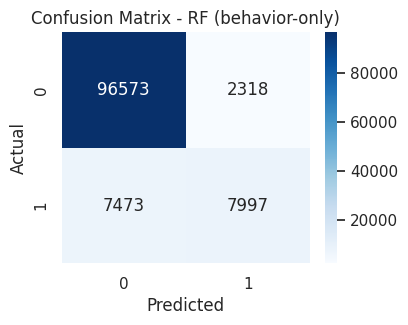

ROC-AUC: 0.9464


In [13]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = rf_behav.predict(X_test)
y_prob = rf_behav.predict_proba(X_test)[:, 1]

print("=== RandomForest (behavior-only) ===")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - RF (behavior-only)")
plt.show()

auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {auc:.4f}")

In [15]:
import pandas as pd

feat_imp = pd.DataFrame({
    "feature": behavior_features,
    "importance": rf_behav.feature_importances_
}).sort_values("importance", ascending=False)

display(feat_imp.head(15))


,feature,importance
2,range_rel,0.183544
13,volz_10d,0.130068
0,ret_3d,0.077695
6,range_3d,0.071958
9,volz_5d,0.071127
17,mkt_cap_pct,0.055842
10,range_5d,0.046837
1,ret_5d,0.045624
5,volz_3d,0.042161
12,turnover_10d,0.036269


In [18]:
data = data.sort_values(["ticker", "date"]).reset_index(drop=True)

g = data.groupby("ticker", group_keys=False)

# 1) Tốc độ thay đổi khối lượng trong 5 ngày
data["vol_change_5d"] = g["volume"].transform(
    lambda x: (x / x.shift(5)) - 1
)

# 2) Tỷ lệ giữa thanh khoản và độ “bất thường” khối lượng
data["turnover_vol_ratio"] = data["turnover"] / (data["vol_z20"].abs() + 1e-6)

# 3) Biên độ giá tuyệt đối 5 ngày (độ “mạnh” của biến động)
data["abs_ret_5d"] = data["ret_5d"].abs()

# 4) Độ biến động 10 ngày (rolling std của ret_1d)
data["volatility_10d"] = g["ret_1d"].transform(
    lambda x: x.rolling(10, min_periods=5).std()
)

# 5) Xu hướng giá 5 ngày (price slope)
data["price_slope_5d"] = g["close"].transform(
    lambda x: (x - x.shift(5)) / 5
)

data[["ticker","date","vol_change_5d","turnover_vol_ratio",
      "abs_ret_5d","volatility_10d","price_slope_5d"]]

,ticker,date,vol_change_5d,turnover_vol_ratio,abs_ret_5d,volatility_10d,price_slope_5d
0,AAA,2020-01-02,NaN,NaN,NaN,NaN,NaN
1,AAA,2020-01-03,NaN,NaN,NaN,NaN,NaN
2,AAA,2020-01-06,NaN,NaN,NaN,NaN,NaN
3,AAA,2020-01-07,NaN,NaN,NaN,NaN,NaN
4,AAA,2020-01-08,NaN,0.009486,NaN,NaN,NaN
...,...,...,...,...,...,...,...
700958,YEG,2024-12-25,0.336106,0.022862,0.393387,0.036478,1.19562
700959,YEG,2024-12-26,-0.512057,0.098544,0.213479,0.047360,0.69364
700960,YEG,2024-12-27,-0.885164,0.002356,0.057896,0.058925,0.20080
700961,YEG,2024-12-30,1.912765,0.045693,0.014778,0.058789,-0.05476


In [19]:
behavior_features = [
    # === feature behavior cũ ===
    "ret_3d","ret_5d",
    "range_rel","close_loc",
    "turnover_3d","volz_3d","range_3d","close_loc_3d",
    "turnover_5d","volz_5d","range_5d","close_loc_5d",
    "turnover_10d","volz_10d","range_10d","close_loc_10d",
    "turnover_pct","mkt_cap_pct",

    # === feature behavior mới thêm ===
    "vol_change_5d",
    "turnover_vol_ratio",
    "abs_ret_5d",
    "volatility_10d",
    "price_slope_5d",
]

label_col = "churn_flag"

# Chuẩn bị dữ liệu model
df_model = data.dropna(subset=behavior_features + [label_col]).copy()

X = df_model[behavior_features]
y = df_model[label_col].astype(int)

print("Shape X, y:", X.shape, y.shape)
print("Tỷ lệ nhãn:")
print(y.value_counts(normalize=True))


Shape X, y: (571805, 23) (571805,)
Tỷ lệ nhãn:
churn_flag
0    0.864725
1    0.135275
Name: proportion, dtype: float64


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

rf_feat = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=3,              # hơi regularize cho ổn định hơn
    n_jobs=-1,
    random_state=42,
    class_weight="balanced_subsample"
)

rf_feat.fit(X_train, y_train)
print("✅ Trained RandomForest với feature behavior mở rộng.")

✅ Trained RandomForest với feature behavior mở rộng.


=== RandomForest (behavior + extra features) ===
              precision    recall  f1-score   support

           0     0.9540    0.9568    0.9554     98891
           1     0.7187    0.7049    0.7117     15470

    accuracy                         0.9228    114361
   macro avg     0.8363    0.8309    0.8336    114361
weighted avg     0.9222    0.9228    0.9224    114361



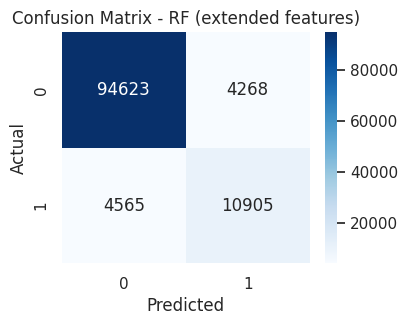

ROC-AUC: 0.9564


In [21]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = rf_feat.predict(X_test)
y_prob = rf_feat.predict_proba(X_test)[:, 1]

print("=== RandomForest (behavior + extra features) ===")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - RF (extended features)")
plt.show()

auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {auc:.4f}")

In [22]:
feat_imp = (
    pd.DataFrame({
        "feature": behavior_features,
        "importance": rf_feat.feature_importances_
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

display(feat_imp)

,feature,importance
0,range_rel,0.169532
1,volz_10d,0.119350
2,volatility_10d,0.106911
3,volz_5d,0.055536
4,vol_change_5d,0.055511
5,range_3d,0.047506
6,ret_3d,0.042176
7,abs_ret_5d,0.040645
8,mkt_cap_pct,0.035420
9,range_5d,0.033386
